# Develop Fixed-radius NN Linear-time Algorithm

Explore the techniques described in [this paper](https://reader.elsevier.com/reader/sd/pii/0020019077900709?token=E45C0E1870EA26C21C1F149B6090CE4630A51269D324BE1206B7BF2764FB48B2DDC93F4B86FBFBD8CBDED63B15BBC6DA&originRegion=us-east-1&originCreation=20210428165528).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics, decomposition
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

import faiss

sys.path.append('/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/Pipelines/TrackML_Example')
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model and Inference

In [3]:
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import graph_intersection, build_edges

In [4]:
chkpt_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints/CodaEmbeddingStudy/pbn07koj"
chkpt_file = "last.ckpt"
chkpt_path = os.path.join(chkpt_dir, chkpt_file)

In [5]:
model = LayerlessEmbedding.load_from_checkpoint(chkpt_path)

In [6]:
model.hparams["train_split"] = [100,10,10]

In [7]:
model.setup(stage="fit")

In [8]:
model = model.to(device)

# Bentley From Scratch

### Test data

In [9]:
batch = model.trainset[1].to(device)
e_bidir = torch.cat(
            [batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1
        ) 

In [10]:
with torch.no_grad():
    spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))

## FAISS Radius/Dimension Scaling

### GPU

In [11]:
import faiss
import torch
import faiss.contrib.torch_utils

In [17]:
r_max = 1.7

In [30]:
%%time
e_spatial = build_edges(spatial, r_max, 200)

CPU times: user 225 ms, sys: 185 ms, total: 410 ms
Wall time: 409 ms


In [31]:
e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir, using_weights=False)

In [32]:
t = e_bidir.shape[1]
tp = y_cluster.sum()
p = e_spatial.shape[1]

In [33]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.9576157331466675, Purity: 0.02455095387995243


In [25]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.9612043499946594, Purity: 0.02271021157503128


## Raw Application

### 0. Setup Constants

In [10]:
r_max = 5
r_query = 1
nb = spatial.shape[0]
d = spatial.shape[1]

### 1. Assign hits to multi-D cells

a) Translate to positive values

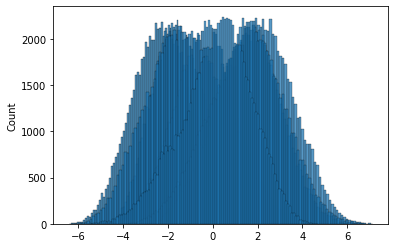

In [11]:
for col in spatial.cpu().T:
    sns.histplot(col)

In [24]:
pos_spatial = (spatial - spatial.min(dim=0)[0].T).half()
spatial_ind = torch.arange(len(pos_spatial), device=device).int()
L_box = pos_spatial.max()

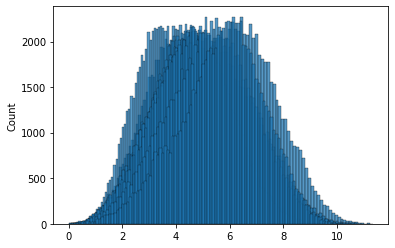

In [25]:
for col in pos_spatial.cpu().T:
    sns.histplot(col)

b) Get multi-D cell ref

In [74]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.6936115622520447, Purity: 0.274589866399765


In [26]:
x_cell_ref = (pos_spatial // r_max).int()

### 2. Build Neighbourhood Lookup

a) Nearest neighbourhood grid

In [27]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

b) Convert multi-D index (e.g. [1, 3, 2, ...]) to a unique index

In [28]:
reshape_dims = [int(L_box // r_max + 1)]*d
cell_index_length = np.product(reshape_dims)
cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

In [29]:
cell_lookup.shape

torch.Size([3, 3, 3, 3, 3, 3, 3, 3])

c) Convert multi-D neighbour grid to unique index lookup

In [30]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0), 0, 1)
hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=d, dim=2)].squeeze()
hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=d, dim=1)].squeeze()

CPU times: user 0 ns, sys: 2.72 ms, total: 2.72 ms
Wall time: 2.33 ms


d) Get non-empty cells to search

In [31]:
%%time
_, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)
D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 15.9 ms


### 3. Naive Search!

In [39]:
torch.cuda.max_memory_allocated()/1024**3

8.219213962554932

In [37]:
%%time
all_radius_edges = []
for i, cell in enumerate(D_cells):
    x_in_cell = spatial_ind[(hit_lookup == cell)]
    x_in_nhood = spatial_ind[(hit_nhood_lookup == cell).any(1)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (pos_spatial[all_cell_combinations[0].long()] - pos_spatial[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])

CPU times: user 468 ms, sys: 137 ms, total: 604 ms
Wall time: 603 ms


In [40]:
all_radius_edges = torch.cat(all_radius_edges, dim = 1)

In [54]:
all_radius_edges = all_radius_edges[:, all_radius_edges[0] != all_radius_edges[1]]

In [61]:
all_radius_edges = torch.cat([all_radius_edges, all_radius_edges.flip(0)], dim=1)

In [62]:
all_radius_edges.shape

torch.Size([2, 879064])

In [63]:
%%time
torch.unique(all_radius_edges, dim=0).shape

CPU times: user 6.77 ms, sys: 0 ns, total: 6.77 ms
Wall time: 4.56 ms


torch.Size([2, 879064])

### 4. Performance Check

In [64]:
all_radius_edges, y_cluster = graph_intersection(all_radius_edges, e_bidir, using_weights=False)

In [65]:
t = e_bidir.shape[1]
tp = y_cluster.sum()
p = all_radius_edges.shape[1]

In [66]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.678562581539154, Purity: 0.27633437514305115


## PCA Approach

### 0. Setup Constants

In [131]:
r_max = 1.5
r_query = 1
nb = spatial.shape[0]
d = spatial.shape[1]

### 1. Build PCA and make positive

In [132]:
#PCA construction
projection_d = 2
pca = decomposition.PCA(n_components = projection_d)

In [133]:
%%time
pca.fit(spatial.cpu())

CPU times: user 140 ms, sys: 80.8 ms, total: 221 ms
Wall time: 118 ms


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [134]:
%%time
spatial_pca = torch.from_numpy(pca.transform(spatial.cpu())).float().to(device)

CPU times: user 28.4 ms, sys: 8.68 ms, total: 37.1 ms
Wall time: 20 ms


In [135]:
%%time
pos_spatial = (spatial_pca - spatial_pca.min(dim=0)[0].T).half()
half_spatial = spatial.half()
spatial_ind = torch.arange(len(pos_spatial), device=device).int()
L_box = pos_spatial.max()

CPU times: user 247 µs, sys: 349 µs, total: 596 µs
Wall time: 406 µs


In [136]:
# Assign grid cells
x_cell_ref = (pos_spatial // r_max).int()

In [137]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*projection_d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [138]:
reshape_dims = [int(L_box // r_max + 1)]*projection_d
cell_index_length = np.product(reshape_dims)
cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

In [139]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, projection_d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), projection_d), 1, 0), 0, 1)
hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=projection_d, dim=2)].squeeze()
hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=projection_d, dim=1)].squeeze()

CPU times: user 201 µs, sys: 288 µs, total: 489 µs
Wall time: 345 µs


In [140]:
%%time
_, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)

CPU times: user 541 µs, sys: 779 µs, total: 1.32 ms
Wall time: 941 µs


In [141]:
%%time
D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

CPU times: user 375 µs, sys: 542 µs, total: 917 µs
Wall time: 720 µs


### 3. Naive Search

In [142]:
torch.cuda.max_memory_allocated()/1024**3

13.59075927734375

In [117]:
%%time
all_radius_edges = []
for i, cell in enumerate(D_cells):
    x_in_cell = spatial_ind[(hit_lookup == cell)]
    x_in_nhood = spatial_ind[(hit_nhood_lookup == cell).any(1)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (half_spatial[all_cell_combinations[0].long()] - half_spatial[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])

CPU times: user 196 ms, sys: 53.2 ms, total: 249 ms
Wall time: 249 ms


In [118]:
%%time
all_radius_edges = torch.cat(all_radius_edges, dim = 1)
all_radius_edges = all_radius_edges[:, all_radius_edges[0] != all_radius_edges[1]]
all_radius_edges = torch.cat([all_radius_edges, all_radius_edges.flip(0)], dim=1)

CPU times: user 413 µs, sys: 569 µs, total: 982 µs
Wall time: 700 µs


In [113]:
%%time
torch.unique(all_radius_edges, dim=0).shape

CPU times: user 2.12 s, sys: 745 ms, total: 2.86 s
Wall time: 2.87 s


torch.Size([2, 923050])

### 4. Performance

In [119]:
all_radius_edges, y_cluster = graph_intersection(all_radius_edges, e_bidir, using_weights=False)

In [120]:
t = e_bidir.shape[1]
tp = y_cluster.sum()
p = all_radius_edges.shape[1]

In [121]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.6759809851646423, Purity: 0.26227235794067383


### 5. Improvements?

In [143]:
%%time
# HIGH MEM VERSION
hit_mask = (hit_lookup[:, None] == D_cells).T
nb_mask = (hit_nhood_lookup[:, :, None] == D_cells).any(1).T

x_in_cell = half_spatial.expand(D_cells.shape[0], -1, -1)[hit_mask]
x_in_nhood = half_spatial.expand(D_cells.shape[0], -1, -1)[nb_mask]

hit_batch = D_cells.expand(hit_mask.shape[1], -1).T[hit_mask]
hit_nb_batch = D_cells.expand(hit_mask.shape[1], -1).T[nb_mask]

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 1.51 ms


In [144]:
%%time
hit_cell_counts = torch.unique(hit_batch, return_counts=True)[1]
hit_cell_cumsum = hit_cell_counts.cumsum(0).roll(1)
hit_cell_cumsum[0] = 0
hit_max = hit_cell_counts.max()
nb_cell_counts = torch.unique(hit_nb_batch, return_counts=True)[1]
nb_cell_cumsum = nb_cell_counts.cumsum(0).roll(1)
nb_cell_cumsum[0] = 0
nb_max = nb_cell_counts.max()

CPU times: user 683 µs, sys: 998 µs, total: 1.68 ms
Wall time: 1.28 ms


In [145]:
%%time
ref_mesh = torch.stack(torch.meshgrid(torch.arange(hit_max, device=device), torch.arange(nb_max, device=device)))

CPU times: user 239 µs, sys: 350 µs, total: 589 µs
Wall time: 401 µs


In [146]:
print(ref_mesh.shape, x_in_cell.shape, x_in_nhood.shape)

torch.Size([2, 7667, 23733]) torch.Size([92650, 8]) torch.Size([362922, 8])


In [147]:
%%time
all_hits = []
all_nbs = []
for cell, hit_count, nb_count, hit_cumsum, nb_cumsum in zip(D_cells, hit_cell_counts, nb_cell_counts, hit_cell_cumsum, nb_cell_cumsum):
    local_edges = torch.flatten(ref_mesh[:, :hit_count, :nb_count], start_dim=1)
    hit_indices = x_in_cell[local_edges[0] + hit_cumsum]
    nb_indices = x_in_nhood[local_edges[1] + nb_cumsum]
    
    edge_mask = torch.sum( (hit_indices - nb_indices)**2, dim=1) < r_query**2
    
    all_hits.append(local_edges[0][edge_mask]+ hit_cumsum)
    all_nbs.append(local_edges[1][edge_mask]+ nb_cumsum)

RuntimeError: CUDA out of memory. Tried to allocate 2.71 GiB (GPU 0; 15.78 GiB total capacity; 8.21 GiB already allocated; 2.58 GiB free; 11.97 GiB reserved in total by PyTorch)

# Packaged and Tested

In [9]:
def build_edges_grid(spatial, r_query, pca, r_max=None):
    
    nb = spatial.shape[0]
    d = spatial.shape[1]
    
    if r_max is None:
        r_max = r_query

    spatial_pca = torch.from_numpy(pca.transform(spatial.cpu())).float().to(device)

    pos_spatial = (spatial_pca - spatial_pca.min(dim=0)[0].T).half()
    half_spatial = spatial.half()
    spatial_ind = torch.arange(len(pos_spatial), device=device).int()
    L_box = pos_spatial.max()

    x_cell_ref = (pos_spatial // r_max).int()

    inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*projection_d)), start_dim=1).T.to(device)
    exclusive_nhood = inclusive_nhood[:-1]

    reshape_dims = [int(L_box // r_max + 1)]*projection_d
    cell_index_length = np.product(reshape_dims)
    cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

    nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, projection_d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), projection_d), 1, 0), 0, 1)
    hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=projection_d, dim=2)].squeeze()
    hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=projection_d, dim=1)].squeeze()

    _, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)

    D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

    all_radius_edges = []
    for i, cell in enumerate(D_cells):
        x_in_cell = spatial_ind[(hit_lookup == cell)]
        x_in_nhood = spatial_ind[(hit_nhood_lookup == cell).any(1)]
        if len(x_in_nhood)>0:
            all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
            all_radius_edges.append(all_cell_combinations[:, torch.sum( (half_spatial[all_cell_combinations[0].long()] - half_spatial[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])

    all_radius_edges = torch.cat(all_radius_edges, dim = 1)
    all_radius_edges = all_radius_edges[:, all_radius_edges[0] != all_radius_edges[1]]
    all_radius_edges = torch.cat([all_radius_edges, all_radius_edges.flip(0)], dim=1)
    
    return all_radius_edges

In [10]:
batch = model.trainset[1].to(device)
e_bidir = torch.cat(
            [batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1
        ) 

In [11]:
with torch.no_grad():
    spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))

In [56]:
r_query = 1.8
r_max = r_query

In [57]:
#PCA construction
projection_d = 3
pca = decomposition.PCA(n_components = projection_d)

In [58]:
%%time
pca.fit(spatial.cpu())

CPU times: user 159 ms, sys: 59.3 ms, total: 219 ms
Wall time: 111 ms


PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [59]:
e_spatial = build_edges_grid(spatial, r_query, pca, r_max)
e_bidir = torch.cat([batch.layerless_true_edges, batch.layerless_true_edges.flip(0)], axis=-1) 
e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir, using_weights=False)

In [60]:
t = e_bidir.shape[1]
tp = y_cluster.sum()
p = e_spatial.shape[1]

In [61]:
print(f'Efficiency: {tp / t}, Purity: {tp / p}')

Efficiency: 0.9465250372886658, Purity: 0.01987643912434578


In [62]:
torch.cuda.max_memory_allocated() / 1024**3

9.887587070465088

### Timing

In [63]:
%%time
timelist = []
with torch.no_grad():
    for i in range(10):
        tic = tt()
        batch = model.trainset[i].to(device)
        spatial = model(torch.cat([batch.cell_data, batch.x], axis=-1))
        e_spatial = build_edges_grid(spatial, r_query, pca, r_max)
        timelist.append(tt() - tic)

CPU times: user 4.22 s, sys: 1.39 s, total: 5.6 s
Wall time: 4.51 s


In [64]:
print(f'Time mean: {np.mean(timelist)} +- {np.std(timelist)}')

Time mean: 0.4511192798614502 +- 0.0674569891412964


# Compare to FNNS

In [3]:
import frnn

In [14]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
# all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [15]:
%%time
# first time there is no cached grid
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=xb.unsqueeze(0), points2=xb.unsqueeze(0), lengths1=None, lengths2=None, K=32, r=1.0, grid=None, return_nn=False, return_sorted=True
)

CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.42 ms


In [17]:
%%time
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=xb.unsqueeze(0), points2=xb.unsqueeze(0), lengths1=None, lengths2=None, K=32, r=1.0, grid=grid, return_nn=False, return_sorted=True
)

CPU times: user 623 µs, sys: 510 µs, total: 1.13 ms
Wall time: 779 µs
